**Authors**: Malthe D. Andersen (s194257), Yucheng Fu (s194241), Andreas Høst (s194238)

In [28]:
# packages
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import requests
import re
import numpy as np
import mwparserfromhell
import urllib.request
import json
import matplotlib.pyplot as plt 
import os
import seaborn as sns
import networkx as nx
import community
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scraping the data

In the following sections, we scrape the [major characters](https://wowpedia.fandom.com/wiki/Major_characters) in the games and their meta data using the BeautifulSoup module. 

The function ``get_importance`` is a helper function that takes 'soup' as input and outputs the importance rating (red, orange, yellow, or green) for the character which the 'soup' belongs to.

In [12]:
games = ['WC1','WC2','WC2X','WC3','WC3X','WoW','WoWBC','WoWWotLK','WoWC','WoWMoP','WoWWoD','WoWL','WoWBfA','WoWS','WoWD']

def get_importance(soup):
    colors = []

    i = 0
    soup_a = soup.select("ul > li")
    for a in soup_a:
        color = re.findall(r'color+:\w+', str(a))

        if len(color) > 0:
            if i > 3:
                colors.append(color[0][6:])
            i += 1
            
    return colors

The ``get_metadata`` function outputs a list of dictionaries with the keys "Name", "Importance". The dictionary also contains information about which game each major character appears in. 

In [13]:
def get_metadata():
    meta_data = []

    # get meta data of all major characters

    url = "https://wowpedia.fandom.com/wiki/Major_characters"
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features="html.parser")

    soup_a = soup.select("p > small")
    soup_b = soup.select("p > a")
    soup_b = [b for b in soup_b if "Katrana" not in str(b) and "Daval" not in str(b)]
    
    colors = get_importance(soup)
            
    for i,s in enumerate(soup_a):
        d = {}

        expansions = s.text.replace(",","").replace("—","").split()
        # make one-hot encoding for games. For each character, a "1" denotes that the character appears in that game, a "0" 
        # the character does not appear in the game.
        expansions = [int(1) if i in expansions else int(0) for i in games]

        text = soup_b[i]['href'][6:]
        color = colors[i]
        
        name = text.replace("%27", "'")

        if 1 in expansions:
            d['Name'] = name
            d['Importance'] = color
            for j,g in enumerate(games):
                d[g] = int(expansions[j])


            meta_data.append(d)
    
    return meta_data

In [10]:
# create dataframe for major characters and their meta data. Then save as .pickle file.

meta_data = get_metadata()
df_meta = pd.DataFrame(meta_data, dtype=object)

with open('df_meta.pickle', 'wb') as handle:
    pickle.dump(df_meta, handle, protocol=pickle.HIGHEST_PROTOCOL)

The ``get_major_characters`` function returns a list of dictionaries for all the names of the major characters. We will use these to find all the characters that are mentioned by the major characters.

In [21]:
def get_major_characters():
    characters = []

    url = "https://wowpedia.fandom.com/wiki/Major_characters"
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features="html.parser")

    soup_a = soup.select("p > small")
    soup_b = soup.select("p > a")
    soup_b = [b for b in soup_b if "Katrana" not in str(b) and "Daval" not in str(b)]
    
    for i,s in enumerate(soup_a):
        d = {}

        expansions = s.text.replace(",","").replace("—","").split()
        expansions = [int(1) if i in expansions else int(0) for i in games]

        text = soup_b[i]['href'][6:]
        name = text.replace("%27", "'")

        if 1 in expansions:
            d['Name'] = name
            
            characters.append(d)
    
    return characters

# make dataframe 
characters = get_major_characters()
df = pd.DataFrame(characters)

The function ``get_wikicode`` is a helper function to access the raw wiki text on Wowpedia, using the Wowpedia API. The input is a character name 't', e.g. Deathwing, and the output is the raw wiki text.

In [24]:
def get_wikicode(t):

    response = requests.get(
         'https://wowpedia.fandom.com/api.php',
             params={
             'action': 'query',
             'format': 'json',
             'titles': '{}'.format(t),
             'prop': 'revisions',
             'rvprop': 'content',
         }
     ).json()


    page = next(iter(response['query']['pages'].values()))

    wikicode = page['revisions'][0]['*']
    
    return wikicode

The following code loops through all the major characters and find characters that are linked from the major character's wiki page. 

We check all hyperlinks on the major character's wiki page. The hyperlinks may link to characters, locations, events, and other miscellaneous pages, but common for all character pages is that only they have an information table with the gender displayed. If the linked page has an information table with the gender displayed, it is a character, and we append them to the character list.

The code takes around 6 hours to run.


In [1]:
characters = []

for i,name in enumerate(tqdm(list(df['Name']))):
    
    text = get_wikicode(name)

    WORD_RE = re.compile(r"\[{2}.*?\]{2}")
    for word in list(np.unique(WORD_RE.findall(text))):
        try:
            char = word.replace(" ", "_")[2:-2]
            if "Category" not in char and ":" not in char and "#" not in char and "|" not in char:
                url = "https://wowpedia.fandom.com/wiki/{}".format(char)
                html = urlopen(url).read()
                soup = BeautifulSoup(html, features="html.parser")
                
                # find the information table
                table =  soup.find("table",{"class":"infobox darktable"})

                if len(table) > 0:

                    text = table.text
                    # check if the infobox displays gender.
                    if "Gender" not in text:
                        pass
                    else:
                        characters.append(char)

        except:
            pass

# there are duplicate characters which we remove. 
characters = list(np.unique(characters))



Furthermore, we perform some manual clean up and filter any character that has some non-alphanumeric characters in the name. Also filter characters that already exist in the data frame.

In [ ]:
filter_characters = []
for char in characters:
    if "/" not in char and "#" not in char and "|" not in char and "tactics" not in char and char not in list(df_meta['Name']):
        filter_characters.append(char)

# append to the existing dataframe with the name of major characters.
df = df.append(pd.DataFrame(filter_characters, columns=['Name']), ignore_index=True)

Now we have collected the characters we will be working with. The next step is to find the affiliation and race of each character.

The functions ``get_race``, ``get_affiliation``, and ``get_race_and_affiliation`` are helper functions. The input to the ``get_race_and_affiliation`` is the infobox from a character's wiki page, and it outputs the Race and Affiliation (using the two other helper functions), which is displayed in the infobox. The affiliations can be either Horde, Alliance or "Other". If the listed affiliation for a character is neither Horde nor Alliance, its affiliation is assigned as "Other". 

In [ ]:
def get_race(tokens, i):
    regex2 = "^[a-zA-z-' ]+[a-zA-Z ]+"
    
    regex_expressions = re.findall(regex2, tokens[i+1])
    
    # join into word
    race = " ".join(regex_expressions).strip()
    
    return race

def get_affiliation(tokens, i):
    regex3 = '[a-zA-z ]+'
    
    to_string = ' '.join(tokens[i:])
    regex_expressions = re.findall(regex3, to_string)
    regex_expressions = [k.strip() for k in regex_expressions]

        
    for i, exp in enumerate(regex_expressions):
        if "Former" in exp:
            break
    regex_expressions = regex_expressions[:i+1]
    
    if any(["Horde" in i for i in regex_expressions]):
        affiliation = "Horde"
    elif any(["Alliance" in i for i in regex_expressions]):
        affiliation = 'Alliance'
    else:
        affiliation = 'Other'
        
    return affiliation

def get_race_and_affiliation(text):

    regex1 = '[a-zA-Z][^A-Z]*'
    
    tokens_race = text.split("\n")
    tokens_affiliation = re.findall(regex1, text.replace("\n",""))

    race = '0'
    affiliation = 'Other'

    for i, word in enumerate(tokens_race):
        if 'Race' in word:
            race = get_race(tokens_race,i)
    for i, word in enumerate(tokens_affiliation):
        if 'Affiliation' in word:
            affiliation = get_affiliation(tokens_affiliation,i)
    
    return race, affiliation


The following code loops through all the characters and outputs a list of races and affiliations for all the characters. The list of races and affiliations are inserted as new columns in the dataframe. 

In [ ]:
races = []
affiliations = []

for name in tqdm(list(df['Name'])):
    try:
        name = name.split("/")[0]
        url = "https://wowpedia.fandom.com/wiki/{}".format(name)
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features="html.parser")
        
        # find information table on characterp page
        table =  soup.find("table",{"class":"infobox darktable"})

        text = table.text

        race, affiliation = get_race_and_affiliation(text)

        races.append(race)
        affiliations.append(affiliation)
    except:
        print(name)
        races.append('0')
        affiliations.append('Other')
        
df.insert(1, 'Race', races)
df.insert(2, 'Affiliation', affiliations)

The infobox lists basic information about the character, such as "Race", "Affiliation(s)", "Former affiliation(s)", "Occupation" etc. Due to how the information is formatted, it might occur that the scraped races might contain artefacts. For instance, there are instances where the race is "TrollAffiliation". These artefacts are removed manually with the code below. 

In [ ]:
races2 = []
for race in df['Race']:
    if race != 0:
        race = race.replace("Affiliation", "").replace("Race", "").replace("Occupation", "").replace("Reaction", "").replace("Resource", "").replace("Race", "").replace("Class", "").replace("Former affiliation", "").replace("Location","").replace("Level", "").replace("Status", "")

    races2.append(race)

df['Race'] = races2

Lastly, for each character we scrape the clean text and find which other characters is linked to. This is done with the code in the following two cells. In some instances, the wiki page is a redirect. This is handled by following the redirect link, and then extracting the information from that page. 

The clean text and links are added to the dataframe as columns.

In [ ]:
text_list = []
for name in tqdm(df['Name']):
    response = requests.get(
         'https://wowpedia.fandom.com/api.php',
             params={
             'action': 'query',
             'format': 'json',
             'titles': '{}'.format(name),
             'prop': 'revisions',
             'rvprop': 'content',
         }
     ).json()

    page = next(iter(response['query']['pages'].values()))
    try:
        wikicode = page['revisions'][0]['*']
        parsed_wikicode = mwparserfromhell.parse(wikicode).strip_code()
        
        # handle redirects
        if parsed_wikicode[:8].upper() == 'REDIRECT':
            t = parsed_wikicode[8:].strip().replace(" ", "_").split("\n")[0]
    
            response = requests.get(
                 'https://wowpedia.fandom.com/api.php',
                     params={
                     'action': 'query',
                     'format': 'json',
                     'titles': '{}'.format(t),
                     'prop': 'revisions',
                     'rvprop': 'content',
                 }).json()

            page = next(iter(response['query']['pages'].values()))
            wikicode2 = page['revisions'][0]['*']
            parsed_wikicode2 = mwparserfromhell.parse(wikicode2).strip_code()

            text_list.append(parsed_wikicode2)
        
        else:
            text_list.append(parsed_wikicode)
    except:
        text_list.append(" ")
    
df.insert(3,'Clean Text',text_list)

In [ ]:
baseurl = "https://wowpedia.fandom.com/api.php?"
action = "action=query"
title = "titles={}"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

WORD_RE = re.compile(r"\[{2}.*?\]{2}")

link_list=[]
for name in tqdm(list(df['Name'])):
    name = ""
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title.format(name), dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    links = []
    # handle redicts
    if "#REDIRECT" in wikitext.upper():
        t = re.findall(r"\[{2}.*?\]{2}", wikitext)[0]
        t = t[2:-2].replace(" ", "_").split("|")[0]
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title.format(t), dataformat)
        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        wikitext2 = wikidata.decode('utf-8')
 
        for word in WORD_RE.findall(wikitext2):
            word = word[2:-2].replace(" ", "_").split("|")[0]
            if word in list(df['Name']) and word not in links:
                links.append(word)
        link_list.append(np.unique(links))

    else:
        for word in WORD_RE.findall(wikitext):
            word = word[2:-2].replace(" ", "_").split("|")[0]
            if word in list(df['Name']) and word not in links:
                links.append(word)
        link_list.append(np.unique(links))
    
df.insert(4,'Out Links',link_list)

We have now scraped all the data that we need! The dataframe is dumped to a pickle file, so we can load it easier.

In [ ]:
with open('df_text.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Network

## Creating the network

## Graphing

## Importance

We create box plots for the degree centrality and betweenness centrality for the major characters. We use the graph G that we created earlier, as well as the meta data dataframe. 

In [9]:
with open('df_meta.pickle', 'rb') as handle:
    df_meta = pickle.load(handle)

with open('GCC.pickle', 'rb') as handle:
    G = pickle.load(handle)

In [10]:
# sort major characters by degree centrality using graph G. 
A = sorted([i for i in nx.degree_centrality(G).items() if i[0] in list(df_meta['Name'])], key=lambda x: x[1], reverse=True)

# get character names and degree centrality seperately
character_names = [a[0] for a in A]
d_centrality = [a[1] for a in A]

# get importance for each major character from dataframe
imp = [df_meta.loc[df_meta['Name'] == b]['Importance'].item() for b in character_names]

In [11]:
# sort major characters by betweenness centrality using graph G. 
A2 = sorted([i for i in nx.betweenness_centrality(G).items() if i[0] in list(df_meta['Name'])], key=lambda x: x[1], reverse=True)

# get betweenness centrality
b_centrality = [a[1] for a in A2]

Using the centrality scores, character names and importance we create two dataframes, one for each type of centrality measure. The box plots are created using the Seaborn module and the dataframes.

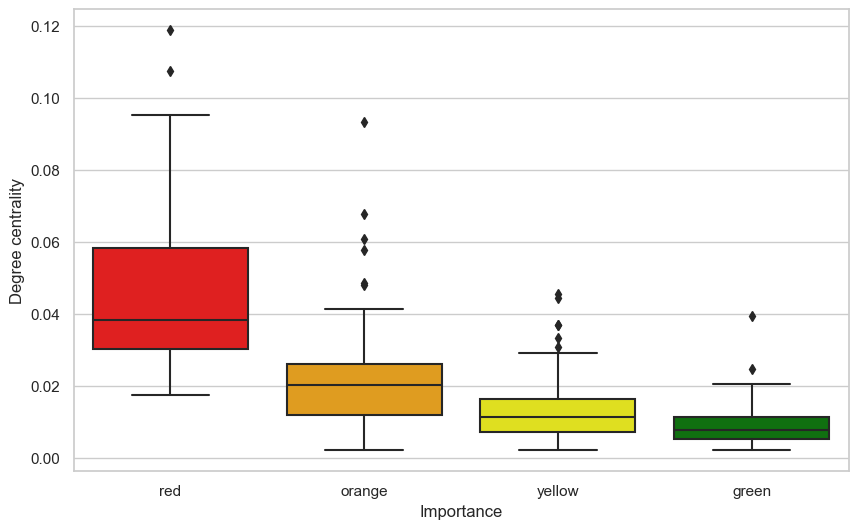

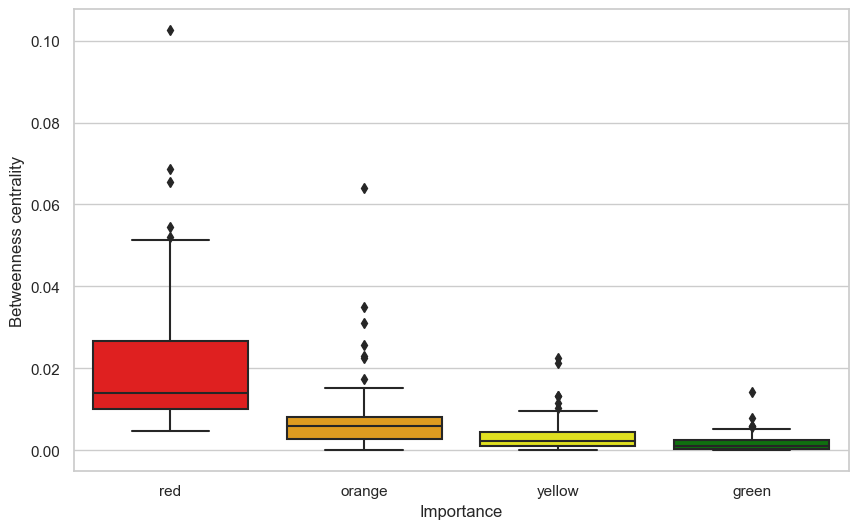

In [14]:
df_box1 = pd.DataFrame(list(zip(character_names, d_centrality, imp)),
               columns =['Name', 'Degree centrality', 'Importance'])
df_box2 = pd.DataFrame(list(zip(character_names, b_centrality, imp)),
               columns =['Name', 'Betweenness centrality', 'Importance'])

# plot box plots
sns.set(rc={'figure.figsize':(10,6)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x='Importance',y='Degree centrality',palette=['red','orange', 'yellow','green'],data=df_box1)
plt.savefig("boxplot.png", dpi=600)
plt.show()

sns.set(rc={'figure.figsize':(10,6)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x='Importance',y='Betweenness centrality',palette=['red','orange', 'yellow','green'],data=df_box2)
plt.savefig("boxplot2.png", dpi=600)
plt.show()

# Text analysis

## TF-IDF and word clouds

To analyse the Louvain partition, we compute the TF-IDF statistic for the 10 largest communities.

Term Frequency (TF) is simply a count of how often a word occurs in a given document. TF can give a good idea of what words are prevalent in a text, however, if you only look at the most frequent words, the words with the highest TF-scores will be uninteresting words like "the", "and", etc. One way to handle this problem is to simpy remove stop-words from the document, however, the most common words excluding stop-words are still not necessarily the words that tells us the most about the given document. 

We can ensure that we get the most defining terms from a document by multiplying TF by the Inverse document frequency (IDF). IDF counts how many documents a given term is in, and outputs the logarithmically scaled inverse frequency, given by the formula:
$$\operatorname{idf}(t, D)=\log \frac{N}{|\{d \in D: t \in d\}|}$$

Where the numerator $N$ is the amount of total documents, in our case 10, and the denomenator is the amount of documents $d\in D$ containing the term $t$. This means the highest IDF-scores are given to terms that appear in only a single document.

The TF-IDF score is then calculated as 

$$\operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)$$

The resulting score shows if terms occur frequently in the given document, and not in other documents. A high TF-IDF score indicates that the given term is used frequently in the given document, and not in others.

(Source: https://en.wikipedia.org/wiki/Tf%E2%80%93idf & assignment 2.)

In [23]:
with open('louvain.pickle', 'rb') as handle:
    partition = pickle.load(handle)
    
with open('df_final.pickle', 'rb') as handle:
    df_final = pickle.load(handle)

There are 14 communities in total, but we only consider the 10 largest communities.

In [24]:
# we count the number of communities:
print("Number of communities:", len(np.unique(list(partition.values()))))

# And count number of nodes in each community:
partitions = np.unique(list(partition.values()))
partition_dic = {parti: [] for parti in partitions}
for parti in partition_dic.keys():
    count = 0
    for key in partition:
        if partition[key] == parti:
            count += 1
    partition_dic[parti]=count
print("Community sizes:",partition_dic)

top_10 = [x[0] for x in sorted(partition_dic.items(), key=lambda x: x[1], reverse=True)][:10]
print("Top 10 largest communities:", top_10)

Number of communities: 14
Community sizes: {0: 161, 1: 130, 2: 212, 3: 235, 4: 221, 5: 125, 6: 137, 7: 10, 8: 6, 9: 140, 10: 212, 11: 195, 12: 128, 13: 49}
Top 10 largest communities: [3, 4, 2, 10, 11, 0, 9, 6, 1, 12]


We first combine all the character texts within each Louvain community. 

In [25]:
community_dic = {part: [] for part in partition_dic.keys()}
for part in tqdm(partition_dic.keys()):#for each community 
    community_doc = str()
    for node in [key for (key,value) in partition.items() if value==part]:#for each character in that community
        tokens = list(df_final.loc[df_final["Name"]==node]['Clean Text'])#Extract clean text from data frame
        
        if len(tokens)!=0:#handle nodes with no text
            community_doc +=' '+ tokens[0]#add extra space to ensure we can split into tokens later
        else:
            break
    
    community_dic[part]=community_doc

  0%|          | 0/14 [00:00<?, ?it/s]

All the texts are then tokenized using ``word_tokenize`` from nltk. Non-alphanumeric characters such as punctuation and signs are removed. 

In [29]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

token_dic = {}
for part in tqdm(community_dic.keys()):#for each community
    tokens = word_tokenize(community_dic[part])#divide text into tokens
    text = community_dic[part]
    token_list = []
    for token in tokens:
        if len(token) != 0:
            token = token.lower()
            
            if token[0] in alphabet and token[-1] in alphabet:#remove punctuation and signs
                token_list.append(token)
    token_dic[part]=token_list

  0%|          | 0/14 [00:00<?, ?it/s]

For each community, we compute the term-frequency (TF) for all tokens. 

In [39]:
TF_outer_dic =  {} 
for part in tqdm(top_10):
    TF_dic = {}
    for token in token_dic[part]:
        if token not in TF_dic.keys():
            TF_dic[token]=token_dic[part].count(token)#count frequency
    TF_outer_dic[part]=TF_dic

For each community, we also compute the inverse document frequency (IDF) for all tokens.

In [38]:
N = 10
IDF_outer_dic = {}
for part in top_10:#for each community
    IDF_dic = {}
    for word in tqdm(TF_outer_dic[part].keys()):#for each word in that community
        
        count = 0
        for part2 in top_10:
            if word in token_dic[part2]:
                count += 1 #count occurences in all documents
        IDF_dic[word]=np.log(N/count)#uses natural log
    IDF_outer_dic[part]=IDF_dic

Finally, we multiply TF and IDF for all tokens to obtain the TF-IDF statistic. 

In [ ]:
TF_IDF_outer_dic = {}
for part in tqdm(top_10):
    TF_IDF_dic = {}
    for word in IDF_outer_dic[part].keys():
        TF_IDF_dic[word]=TF_outer_dic[part][word]*IDF_outer_dic[part][word]
    TF_IDF_outer_dic[part]=TF_IDF_dic

We can now generate word clouds for the 10 largest communities. The size of the words on the word clouds are proportional to the TF-IDF statistic. The function ``random_color_func`` generates a random set of hue, saturation and lightness values which we will use to colour the word clouds. It is adapted from: https://stackoverflow.com/a/43043723

In [50]:
# adapted from: https://stackoverflow.com/a/43043723

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * float(np.random.randint(0, 255)) / 255.0)
    s = int(100.0 * float(np.random.randint(0, 255)) / 255.0)
    l = int(100.0 * float(np.random.randint(0, 255)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

The word clouds are created using the Word Cloud module.

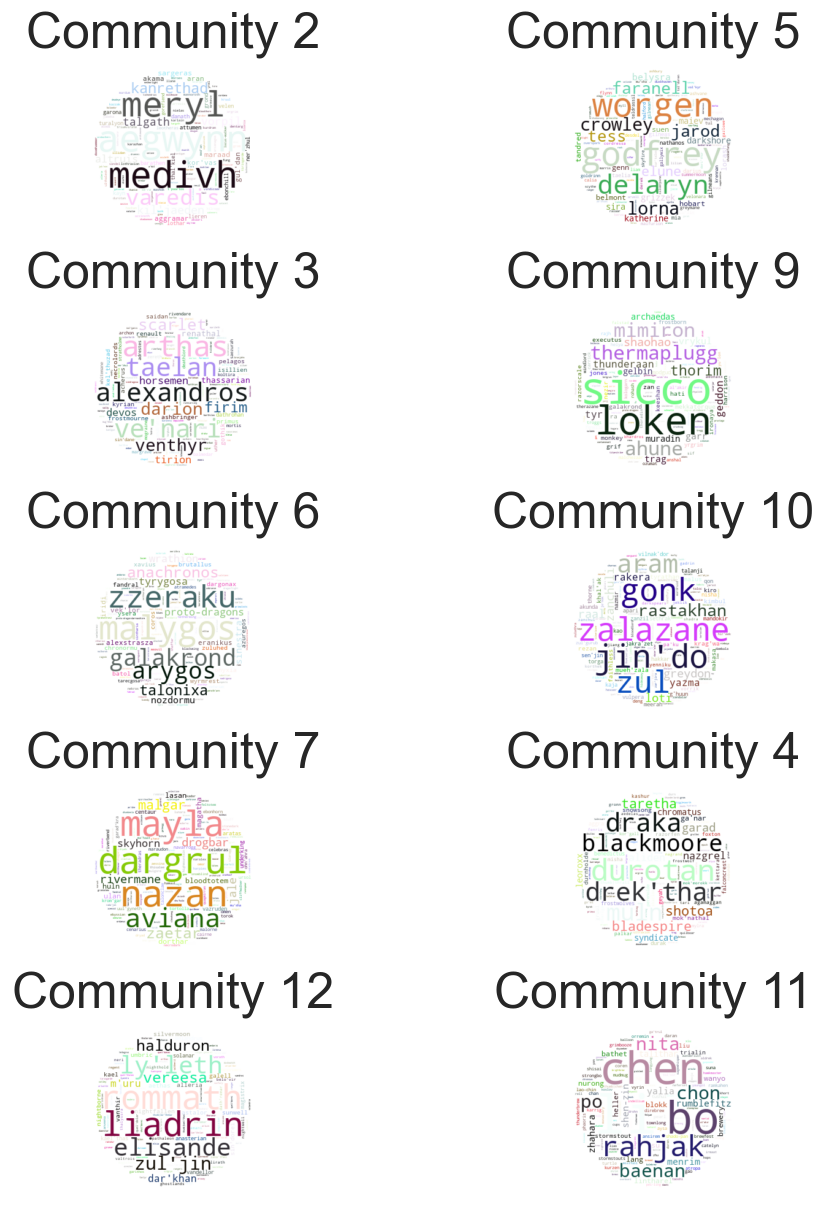

In [54]:
# taken from: https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py

tf_idf = TF_IDF_outer_dic

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

fig = plt.figure(figsize=(8,10),dpi=120,constrained_layout=True)
i=1

for key in tf_idf.keys():
    TF_IDF = tf_idf[key]
    
    wc = WordCloud(background_color="white", repeat=True, mask=mask, color_func=random_color_func)
    # make wordcloud from TF-IDF
    wordcloud = wc.generate_from_frequencies(TF_IDF)
    
    ax = fig.add_subplot(5,2,i)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title("Community {}".format(key), size=30)
    ax.axis("off")
    i+=1

plt.savefig("wordclouds.png", dpi=400);
    
plt.show()

## Sentiment analysis